# Static Regret Analysis

### Goal: Evaluate baseline claims made by the paper of asymptotically near-zero instantaneous regret.


#### Theorem: $\gamma$-Sample Complexity Bound
Fix a target average regret $\gamma>0$, maximal deletions $m\in\mathbb{N}$, and confidence $\delta_B\in(0,1)$.
Let $S_{N}=\sum_{t=1}^N\|g_t\|^{2}$ and suppose (i) the adaptive regret bound
and (ii) the aggregate deletion noise contribution hold with probability at least $1-\delta_B$.
Then any horizon $N$ such that
$$
\frac{1}{N}\,R_{N}(m)\;=\;\frac{GD\sqrt{c\,C\,S_{N}}+\Delta_m}{N}\;\le\;\gamma
$$
guarantees $\frac{1}{N}R_{N}(m)\le\gamma$ with probability $\ge 1-\delta_B$.

The main goal is to prove the regret decomposition provided in the paper. We demonstrate not only square-root growth of the regret curve, but break down that regret curve into static and dynamic components. If the theory is correct, the dynamic term should increase linearly in direct proportion to the strength of the stream's drift.

The configuration grid can be found below:

```yaml
matrix:
  # Core regret / capacity controls (reduced for manageable combinations)
  gamma_bar:       [1.0, 1.2]             # Total regret budget
  gamma_split:     [0.5, 0.6]             # Fraction allocated to insertions vs deletions
  
  # Privacy parameters
  eps_total:       [1.0, 2.0]             # Total epsilon budget
  delta_total:     [1e-5]                  # Total delta budget
  lambda_:          [0.1, 0.2]             # Strong convexity parameter
  delta_b:          [0.05, 0.1]            # Regret bound failure probability
  
  # Theory-first stream targets for regret decomposition
  target_G:         [2.0, 2.5]             # Gradient norm bound
  target_D:         [2.0, 2.5]             # Domain diameter
  target_c:         [0.05, 0.1]            # Lower curvature bound
  target_C:         [10.0, 20.0]           # Upper curvature bound
  target_lambda:    [0.05, 0.1]            # Theory strong convexity
  target_PT:         [30.0, 40.0]          # Total path length
  target_ST:         [100000.0, 200000.0]   # AdaGrad energy target
  
  # Stream configuration
  path_style:       ["rotating"]            # Path evolution style
  dim:              [20]                   # Dimensionality
  T:                [50000]                # Horizon
  accountant:       ["zcdp"]               # Privacy accountant
  
  # Algorithm settings
  algo:             ["memorypair"]         # Algorithm to use
  dataset:          ["synthetic"]          # Dataset type
  
  # Deletion parameters
  delete_ratio:     [5.0, 10.0]            # Inserts per delete
  max_events:       [10000]                # Maximum events
  
  # Regularization and stability
  lambda_reg:       [0.01, 0.05]          # L2 regularization
  m_max:            [8]                   # L-BFGS memory pairs
  eta_max:          [1.0]                  # Maximum step size
  adagrad_eps:      [1e-12]               # AdaGrad epsilon
  D_bound:          [2.0]                  # Diameter bound
  
  # Feature flags for regret decomposition analysis
  enable_oracle:    [false]                 # Enable oracle for regret decomposition
  drift_adaptation: [false]                # Disable drift adaptation for cleaner analysis
  
  # Output and logging
  seeds:            [42]                  # Random seed
  bootstrap_iters:  [500]                  # Bootstrap iterations
  output_granularity: ["seed"]             # Output granularity

# Optional: Include specific combinations for focused analysis
include:
  - where:
      gamma_bar: 1.0
      gamma_split: 0.6
      eps_total: 1.0
      target_G: 2.0
      target_D: 2.0
      enable_oracle: true
  - where:
      gamma_bar: 1.2
      gamma_split: 0.7
      eps_total: 2.0
      target_G: 2.5
      target_D: 2.5
      enable_oracle: true

# Limit total combinations for manageable execution
limit: 50
```

### Setup and data loading

The data from simulations is stored in parquet files for efficient memory storage. This allows us to query the data using SQL as we would in any relational database.

This notebook uses DuckDB to query Parquet event and grid datasets under 

This notebook uses DuckDB to query Parquet event datasets under `results_parquet/01_static_regret_decomposition/events/` and `results_parquet/01_static_regret_decomposition/grids` respectively. This infrastructure allows us to query without loading all the data into memory. If DuckDB isn't installed, please `pip install duckdb`.

In [1]:
# print all files in the current working directory
import os
import glob
print(os.listdir('.'))

from pathlib import Path

# Imports and display config
import os, sys, json, math
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

current_dir = Path('/workspaces/unlearning-research-meta/experiment')

directories = sorted([p for p in (Path(current_dir) / 'results_parquet/1b_static_regret_decomposition/').glob('**/grid_id*') if p.is_dir()])

# print number of found grid id partitions
print(f"Found {len(directories)} grid id partitions")

['artifacts', '03_path_length_sensitivity.ipynb', '07_lbfgs_memory_stability.ipynb', '10_accuracy_regret_tradeoff.ipynb', 'README_standardized_analysis.md', '08_drift_detection_and_oracle.ipynb', '06_regret_gate_behavior.ipynb', '1a_dynamic_regret_decomposition.ipynb', '05_privacy_budget_vs_capacity.ipynb', '02_strong_convexity_vs_static_regret.ipynb', '04_stepsize_policy_ablation.ipynb', '1b_static_regret_decomposition.ipynb', '09_noise_ablation_unlearning.ipynb']
Found 100 grid id partitions


In [2]:
# Custom Color Palette Configuration
CUSTOM_PALETTE = {
    'aquamarine': '#b5ffe1',
    'celadon': '#93e5ab', 
    'mint': '#65b891',
    'dark_cyan': '#4e878c',
    'dark_green': '#00241b'
}

# Create a list of colors for easy use in plots
COLOR_SEQUENCE = [
    CUSTOM_PALETTE['aquamarine'],
    CUSTOM_PALETTE['celadon'],
    CUSTOM_PALETTE['mint'],
    CUSTOM_PALETTE['dark_cyan'],
    CUSTOM_PALETTE['dark_green']
]

# Configure matplotlib to use our custom color palette
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=COLOR_SEQUENCE)
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['axes.edgecolor'] = CUSTOM_PALETTE['dark_green']
plt.rcParams['axes.labelcolor'] = CUSTOM_PALETTE['dark_green']
plt.rcParams['text.color'] = CUSTOM_PALETTE['dark_green']
plt.rcParams['xtick.color'] = CUSTOM_PALETTE['dark_green']
plt.rcParams['ytick.color'] = CUSTOM_PALETTE['dark_green']
plt.style.use('dark_background')


# Configure seaborn to use our custom palette
sns.set_theme()
sns.set_palette(COLOR_SEQUENCE)
# Set seaborn style parameters to match our theme
sns.set_style("darkgrid", {
    'axes.edgecolor': CUSTOM_PALETTE['dark_green'],
    'axes.labelcolor': CUSTOM_PALETTE['dark_green'],
    'text.color': CUSTOM_PALETTE['dark_green'],
    'xtick.color': CUSTOM_PALETTE['dark_green'],
    'ytick.color': CUSTOM_PALETTE['dark_green'],
    'grid.color': CUSTOM_PALETTE['celadon'],
    'grid.alpha': 0.3
})


# DuckDB for fast, low-memory Parquet scans
# use the previous list of files

try:
    import duckdb
    HAVE_DUCKDB = True
except Exception:
    HAVE_DUCKDB = False
    # Change to read from the specified folder
    BASE_RESULTS = Path('../results_parquet')
    EVENT_DATASETS = [BASE_RESULTS / '1b_static_regret_decomposition/events'] if (BASE_RESULTS / '1b_static_regret_decomposition/events').is_dir() else []
    if not EVENT_DATASETS:
        raise FileNotFoundError("No 'events' datasets found under the specified path.")
    events_dir = EVENT_DATASETS[0]  # Use the single events directory
    base_parquet_dir = events_dir.parent
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 140)

# Discover event-level Parquet datasets under results/**/parquet/events
BASE_RESULTS = Path('../results_parquet')
directories = sorted([p for p in (current_dir / 'results_parquet/1b_static_regret_decomposition/events').glob('**/grid_id*') if p.is_dir()])
if not directories:
    raise FileNotFoundError("No 'events' datasets found under results_parquet/1b_static_regret_decomposition/**/parquet/")

# Establish a DuckDB connection and create an 'events' view
if not HAVE_DUCKDB:
    raise RuntimeError('DuckDB not installed; please `pip install duckdb` for low-memory analysis.')
con = duckdb.connect()
# Optional: cap DuckDB memory usage to avoid OOM (adjust as needed)
try:
    con.execute("SET memory_limit='1GB'")
except Exception:
    pass
events_dir = BASE_RESULTS / '1b_static_regret_decomposition/events'
pat = str(events_dir / '**/*.parquet')
con.execute(f"CREATE OR REPLACE VIEW events AS SELECT * FROM read_parquet('{pat}')")
# Inspect available columns once for conditional logic later and sort for consistency
# also include the grid ID in the events view
cols = sorted([d[0] for d in con.execute(f"SELECT * FROM read_parquet('{pat}') LIMIT 1").description])
print('Columns available:', cols)


Columns available: ['C_hat_1', 'D_hat', 'G_hat', 'N_gamma', 'PT_target_residual', 'P_T', 'P_T_est', 'P_T_true', 'ST_running', 'ST_target_residual', 'S_scalar', 'acc', 'accountant', 'accountant_type', 'avg_regret', 'avg_regret_with_noise', 'base_eta_t', 'c_hat', 'capacity_remaining', 'clip_applied', 'comparator_type', 'cum_regret', 'cum_regret_with_noise', 'd_norm', 'deletion_capacity', 'delta_P', 'delta_step_theory', 'delta_total', 'drift_boost_remaining', 'drift_flag', 'eps_remaining', 'eps_spent', 'eps_step_theory', 'eta_t', 'event', 'event_id', 'event_type', 'events_seen', 'g_norm', 'grid_id', 'is_calibrated', 'lambda_est', 'lambda_raw', 'm_capacity', 'm_used', 'noise', 'noise_regret_cum', 'noise_regret_increment', 'op', 'pair_admitted', 'pair_damped', 'path_regret_increment', 'privacy_spend_running', 'regret', 'regret_dynamic', 'regret_increment', 'regret_path_term', 'regret_static_term', 'rho_remaining', 'rho_spent', 'rho_step', 'rho_total', 'sample_id', 'sc_active', 'sc_stable', 

### Phases of the Experiment

The experiment proceeds in four distinct phases, each tied to the theoretical guarantees of the Memory Pair framework.


#### 1. Calibration

We first verify theoretical properties of the data stream using a constant 500 steps to measure stream properties. Constants such as the Lipschitz bound $G$, domain diameter $D$, and curvature spectrum $(c, C)$ are estimated to ensure the strong convexity assumption:

$$
f(y) \;\geq\; f(x) + \nabla f(x)^\top (y - x) + \frac{\lambda}{2}\|y - x\|^2.
$$

This ensures that regret bounds and capacity formulas derived later are valid.

---

#### 2. Warmup

During warmup, the learner collects enough samples to reach the **sample complexity threshold** $N_\gamma$. This is the minimum horizon such that the average regret drops below a target $\gamma$:

$$
\frac{1}{N} R_N \;\leq\; \gamma, \qquad 
R_N := \sum_{t=1}^N \bigl(\ell_t(w_t) - \ell_t(w^\star)\bigr).
$$

Only after $N_\gamma$ events does the deferred inference gate open, ensuring predictions are **PAC-competitive from the start**.

---

#### 3. Workload

In the workload phase, the model processes an interleaved stream of **insert** and **delete** events:
$$
E_t \in \{\text{insert}(x_t, y_t), \text{delete}(u_t)\}.
$$

- Insertions update the model via quasi-Newton (L-BFGS) steps.  
- Deletions trigger symmetric unlearning steps, consuming from the **deletion-capacity odometer**.

Dynamic regret is bounded by both a static term and a drift-dependent path-length term:

$$
R^{\text{dyn}}_T = O\!\left(\frac{G^2}{\lambda}\ln T \;+\; G P_T\right),
\quad
P_T = \sum_{t=2}^T \|w_t^\star - w_{t-1}^\star\|_2.
$$

---

#### 4. Finalization

At the conclusion of the workload, we finalize the **odometer** and check whether deletion capacity $m$ was respected:

$$
m \;\leq\; \frac{\gamma N - GD\sqrt{cC S_N}}{G \sigma_{\text{step}} \sqrt{2 \ln(1/\delta_B)}},
\quad
S_N = \sum_{t=1}^N \|g_t\|^2.
$$

If $m$ has been exhausted, the model must be retrained to preserve accuracy and fidelity guarantees.


In [3]:
# group events by grid_id and operation, counting occurrences
event_counts = con.execute("""
SELECT grid_id, op, COUNT(*) AS count
FROM events
GROUP BY grid_id, op
ORDER BY grid_id, op
""").df()

### Analyzing the Distributions of Operation Counts Across Grid IDs

When I look at the graph above I notice an interesting trend. The sample complexities are largely consistent for many of the grid cells. Calibration is firmly set to 1500 steps and so this makes sense, but that isn't necessarily the case for other phases of the experiment.

The number of `warmup` steps falls into two regimes of almost discrete values. The same can be said of the `insert` and `delete` steps, as well. I wonder whether this would suggest a degree of consistency that isn't exactly intentional.

I'd like to see how consistent the parameters are across these cells. If the parameters for the sample complexity are exactly the same then I could understand some overlap in the values. Otherwise, I'm afraid we might be duplicating regret values. Or maybe some of the parameter variations aren't effective. I'd like to explore this further.

In [4]:
# Load grid parameters from results_parquet/grids and register as a DuckDB view
from pathlib import Path

BASE_RESULTS = Path('../results_parquet')
grids_root = BASE_RESULTS / '1a_dynamic_regret_decomposition/grids'

# Prefer Parquet if available; otherwise fall back to params.json files
grid_parquet_files = list(grids_root.rglob('*.parquet')) if grids_root.exists() else []
if grid_parquet_files:
    pat_grids = str(grids_root / '**/*.parquet')
    grids_df = con.execute(f"SELECT * FROM read_parquet('{pat_grids}')").df()
else:
    rows = []
    if grids_root.exists():
        for params_path in grids_root.rglob('params.json'):
            try:
                # Extract grid_id from folder name like grid_id=<ID>
                parent_name = params_path.parent.name
                gid = parent_name.split('=', 1)[1] if 'grid_id=' in parent_name else parent_name
                with open(params_path, 'r') as f:
                    params = json.load(f)
                params['grid_id'] = gid
                rows.append(params)
            except Exception:
                continue
    grids_df = pd.DataFrame(rows)

# Keep a canonical name used elsewhere
params_df = grids_df.copy()

# Make available to SQL for joins
try:
    con.unregister('grids_df')
except Exception:
    pass
if not params_df.empty:
    con.register('grids_df', params_df)
    con.execute('CREATE OR REPLACE VIEW grids AS SELECT * FROM grids_df')

print('grids/params_df shape:', params_df.shape)
params_df.head()

grids/params_df shape: (50, 71)


,C_hat,D_bound,D_cap,D_hat,G_hat,accountant,adagrad_eps,adaptive_geometry,adaptive_privacy,algo,alphas,bootstrap_iters,c_hat,comparator,d_max,dataset,delete_ratio,delta_b,delta_total,disable_regret_gate,drift_adaptation,drift_kappa,drift_mode,drift_rate,drift_threshold,drift_window,dynamic_comparator,ema_beta,enable_oracle,enforce_nonnegative_regret,eps_total,eta_max,gamma_bar,gamma_split,grid_id,hessian_clamp_eps,lambda_,lambda_cap,lambda_est_beta,lambda_est_bounds,lambda_floor,lambda_min_threshold,lambda_reg,lambda_stability_K,lambda_stability_min_steps,m_max,max_events,online_standardize,output_granularity,pair_admission_m,parquet_only_mode,parquet_out,quantile,recal_threshold,recal_window,regret_comparator_mode,regret_warmup_threshold,relaxation_factor,rho_total,rotate_angle,sens_calib,strong_convexity,target_C,target_D,target_G,target_PT,target_ST,target_c,target_lambda,trim_quantile,window_erm
0,None,2.0,10.0,None,None,zcdp,0.0,False,False,memorypair,"[1.5, 2, 3, 4, 8, 16, 32, 64, inf]",500,None,dynamic,inf,synthetic,10.0,0.05,0.00001,False,False,0.5,False,0.001,0.1,10,False,0.9,True,True,1.0,1.0,1.0,0.5,a4a1adbdc227,0.0,0.1,1000.0,0.1,"[1e-08, 1000000.0]",0.000001,0.000001,0.01,100,100,8,10000,False,seed,0.000001,True,results_parquet/1a_dynamic_regret_decomposition,0.95,0.3,None,oracle,None,0.8,1.0,0.01,50,False,10.0,2.0,2.0,30.0,100000.0,0.05,0.05,0.95,False
1,None,2.0,10.0,None,None,zcdp,0.0,False,False,memorypair,"[1.5, 2, 3, 4, 8, 16, 32, 64, inf]",500,None,dynamic,inf,synthetic,5.0,0.05,0.00001,False,False,0.5,False,0.001,0.1,10,False,0.9,True,True,1.0,1.0,1.0,0.5,037cdba6d990,0.0,0.1,1000.0,0.1,"[1e-08, 1000000.0]",0.000001,0.000001,0.05,100,100,8,10000,False,seed,0.000001,True,results_parquet/1a_dynamic_regret_decomposition,0.95,0.3,None,oracle,None,0.8,1.0,0.01,50,False,10.0,2.0,2.0,40.0,100000.0,0.05,0.10,0.95,False
2,None,2.0,10.0,None,None,zcdp,0.0,False,False,memorypair,"[1.5, 2, 3, 4, 8, 16, 32, 64, inf]",500,None,dynamic,inf,synthetic,10.0,0.05,0.00001,False,False,0.5,False,0.001,0.1,10,False,0.9,True,True,1.0,1.0,1.0,0.5,22c549ab9f73,0.0,0.1,1000.0,0.1,"[1e-08, 1000000.0]",0.000001,0.000001,0.01,100,100,8,10000,False,seed,0.000001,True,results_parquet/1a_dynamic_regret_decomposition,0.95,0.3,None,oracle,None,0.8,1.0,0.01,50,False,10.0,2.0,2.0,30.0,200000.0,0.05,0.10,0.95,False
3,None,2.0,10.0,None,None,zcdp,0.0,False,False,memorypair,"[1.5, 2, 3, 4, 8, 16, 32, 64, inf]",500,None,dynamic,inf,synthetic,10.0,0.05,0.00001,False,False,0.5,False,0.001,0.1,10,False,0.9,True,True,1.0,1.0,1.0,0.5,10f2f0427eb8,0.0,0.1,1000.0,0.1,"[1e-08, 1000000.0]",0.000001,0.000001,0.05,100,100,8,10000,False,seed,0.000001,True,results_parquet/1a_dynamic_regret_decomposition,0.95,0.3,None,oracle,None,0.8,1.0,0.01,50,False,10.0,2.0,2.0,30.0,200000.0,0.05,0.05,0.95,False
4,None,2.0,10.0,None,None,zcdp,0.0,False,False,memorypair,"[1.5, 2, 3, 4, 8, 16, 32, 64, inf]",500,None,dynamic,inf,synthetic,10.0,0.05,0.00001,False,False,0.5,False,0.001,0.1,10,False,0.9,True,True,1.0,1.0,1.0,0.5,14e401030ba4,0.0,0.1,1000.0,0.1,"[1e-08, 1000000.0]",0.000001,0.000001,0.01,100,100,8,10000,False,seed,0.000001,True,results_parquet/1a_dynamic_regret_decomposition,0.95,0.3,None,oracle,None,0.8,1.0,0.01,50,False,20.0,2.0,2.0,30.0,100000.0,0.05,0.05,0.95,False


In [5]:
# Merge event counts with grid params (params_df)
if 'params_df' in globals() and not params_df.empty:
    merged = event_counts.merge(params_df, on="grid_id", how='left')
    # Example: compare warmup counts by gamma_bar if present
    if 'gamma_bar' in merged.columns:
        merged[merged["op"] == "warmup"].groupby("gamma_bar")["count"].unique()
    else:
        print("Column 'gamma_bar' not found in params; showing merged head.")
        merged.head()
else:
    print("params_df is empty or undefined; skipping merge preview.")

In [6]:
# Minimal peek at a few rows for schema intuition (safe LIMIT)
peek = con.execute("SELECT * FROM events WHERE event_type not in ('calibrate', 'warmup') LIMIT 5").df()
print('Peek at events (5 rows):')
peek


Peek at events (5 rows):


,event_type,event,op,regret,acc,accountant_type,eps_spent,capacity_remaining,sigma_step_theory,sample_id,event_id,segment_id,x_norm,delta_P,w_star_norm,noise,theory_targets,G_hat,D_hat,c_hat,C_hat_1,P_T_true,g_norm,clip_applied,ST_running,PT_target_residual,ST_target_residual,sigma_step,privacy_spend_running,S_scalar,eta_t,lambda_est,eps_step_theory,delta_step_theory,rho_step,P_T,comparator_type,drift_flag,regret_dynamic,regret_static_term,regret_path_term,sens_delete,P_T_est,drift_boost_remaining,base_eta_t,regret_increment,cum_regret,avg_regret,noise_regret_increment,noise_regret_cum,cum_regret_with_noise,avg_regret_with_noise,N_gamma,rho_spent,deletion_capacity,rho_total,lambda_raw,sc_stable,pair_admitted,pair_damped,d_norm,sc_active,static_regret_increment,path_regret_increment,accountant,m_capacity,m_used,eps_remaining,rho_remaining,delta_total,is_calibrated,events_seen,stepsize_policy,stepsize_params,sigma_delete,static_oracle_norm,grid_id,seed
0,insert,1075,insert,0.368022,0.863837,None,NaN,NaN,156.087466,theory_001072,1072,0,8.944272,0.00311,1.0,0.058608,<NA>,2.0,2.0,0.05,10.0,3.230273,0.025297,False,354.892745,0.000376,-0.966925,156.087466,0.0,111629.893920,0.005986,79.729935,<NA>,<NA>,1.0,0.0,static,False,0.368022,0.368022,0.0,<NA>,0.0,0,0.005986,0.368022,0.368022,0.000359,0.0,0.0,0.368022,0.000359,526.0,0.0,1,1.0,79.888704,1026,True,False,0.096700,False,0.0,0.0,zcdp,1,0,<NA>,1.0,0.00001,True,1,adagrad,"{'D': 2.0, 'S_t': 111629.89392038732, 'eta_for...",NaN,0.0,02d3b8132076,0
1,insert,1076,insert,-0.200306,0.111446,None,NaN,NaN,156.087466,theory_001073,1073,0,8.944271,0.00311,1.0,0.044917,<NA>,2.0,2.0,0.05,10.0,3.233383,0.025297,False,354.893385,0.000379,-0.966956,156.087466,0.0,111630.882036,0.005986,79.749537,<NA>,<NA>,1.0,0.0,static,False,0.167716,0.167716,0.0,<NA>,0.0,0,0.005986,-0.200306,0.167716,0.000163,0.0,0.0,0.167716,0.000163,526.0,0.0,1,1.0,79.925962,1027,True,False,0.012536,False,0.0,0.0,zcdp,1,0,<NA>,1.0,0.00001,True,2,adagrad,"{'D': 2.0, 'S_t': 111630.8820356578, 'eta_form...",NaN,0.0,02d3b8132076,0
2,insert,1077,insert,0.278426,0.772224,None,NaN,NaN,156.087466,theory_001074,1074,0,8.944273,0.00311,1.0,0.284945,<NA>,2.0,2.0,0.05,10.0,3.236493,0.025297,False,354.894025,0.000383,-0.966987,156.087466,0.0,111678.664444,0.005985,79.755714,<NA>,<NA>,1.0,0.0,static,False,0.446142,0.446142,0.0,<NA>,0.0,0,0.005985,0.278426,0.446142,0.000434,0.0,0.0,0.446142,0.000434,526.0,0.0,1,1.0,79.811305,1028,True,False,0.087305,False,0.0,0.0,zcdp,1,0,<NA>,1.0,0.00001,True,3,adagrad,"{'D': 2.0, 'S_t': 111678.66444413316, 'eta_for...",NaN,0.0,02d3b8132076,0
3,insert,1078,insert,0.161287,0.687767,None,NaN,NaN,156.087466,theory_001075,1075,0,8.944272,0.00311,1.0,0.223218,<NA>,2.0,2.0,0.05,10.0,3.239603,0.025297,False,354.894665,0.000387,-0.967017,156.087466,0.0,111716.581144,0.005984,79.770844,<NA>,<NA>,1.0,0.0,static,False,0.607429,0.607429,0.0,<NA>,0.0,0,0.005984,0.161287,0.607429,0.000590,0.0,0.0,0.607429,0.000590,526.0,0.0,1,1.0,79.907013,1029,True,False,0.077263,False,0.0,0.0,zcdp,1,0,<NA>,1.0,0.00001,True,4,adagrad,"{'D': 2.0, 'S_t': 111716.58114419611, 'eta_for...",NaN,0.0,02d3b8132076,0
4,insert,1079,insert,0.010796,0.461632,None,NaN,NaN,156.087466,theory_001076,1076,0,8.944273,0.00311,1.0,-0.076662,<NA>,2.0,2.0,0.05,10.0,3.242712,0.025297,False,354.895305,0.000390,-0.967048,156.087466,0.0,111733.630687,0.005983,79.783065,<NA>,<NA>,1.0,0.0,static,False,0.618225,0.618225,0.0,<NA>,0.0,0,0.005983,0.010796,0.618225,0.000600,0.0,0.0,0.618225,0.000600,526.0,0.0,1,1.0,79.893058,1030,True,False,0.051211,False,0.0,0.0,zcdp,1,0,<NA>,1.0,0.00001,True,5,adagrad,"{'D': 2.0, 'S_t': 111733.63068724792, 'eta_for...",NaN,0.0,02d3b8132076,0


In [7]:
# Per-seed summary using DuckDB aggregation (low-memory)
cols = set([c[0] for c in con.execute('SELECT * FROM events LIMIT 1').description])
has_op = 'op' in cols
has_regret = 'regret' in cols
has_acc = 'acc' in cols
has_eps = 'eps_spent' in cols

selects = [
    'grid_id',
    'seed',
    'COUNT(*) AS events'
]
if has_op:
    selects += [
        "SUM(CASE WHEN op = 'insert' THEN 1 ELSE 0 END) AS inserts",
        "SUM(CASE WHEN op = 'delete' THEN 1 ELSE 0 END) AS deletions",
    ]
if has_regret:
    selects += [
        'AVG(regret) AS avg_regret',
        'STDDEV_SAMP(regret) AS regret_std'
    ]
if has_acc:
    selects.append('AVG(acc) AS avg_acc')
if has_eps:
    # Approx final epsilon via max if no event order column exists
    # (for monotone spend this is fine).
    selects.append('MAX(eps_spent) AS final_eps_spent')

sql = f"SELECT {', '.join(selects)} FROM events GROUP BY grid_id, seed"
summary = con.execute(sql).df()
print('summary shape:', summary.shape)
summary.head(10)


summary shape: (250, 9)


,grid_id,seed,events,inserts,deletions,avg_regret,regret_std,avg_acc,final_eps_spent
0,f2a66d3336d0,0,9950,8570.0,856.0,-0.258449,0.387743,0.179901,0.0
1,f1edf5f388a4,4,9950,0.0,0.0,0.000000,0.000000,3.273702,0.0
2,f1edf5f388a4,1,9950,6521.0,652.0,1.370738,2.524662,1.836247,0.0
3,f1edf5f388a4,2,9950,7859.0,785.0,0.413351,1.122704,1.074417,0.0
4,f193b336e614,4,9950,0.0,0.0,0.000000,0.000000,3.769070,0.0
5,f193b336e614,2,9950,7996.0,799.0,-0.203514,0.344441,0.291843,0.0
6,e937a150cbf5,4,9950,0.0,0.0,0.000000,0.000000,1.661932,0.0
7,e937a150cbf5,3,9950,3132.0,313.0,-0.104151,0.519429,0.885297,0.0
8,e0ce5229da44,0,9950,8579.0,857.0,-0.262798,0.386693,0.179813,0.0
9,e0a4b9b67329,3,9950,6214.0,621.0,0.894873,2.232371,1.697561,0.0


## Analyzing the Per-Seed Summary

There only appears to be one `grid_id` that was tested for this run of simulations.

I'm re-running the `grid_runner` command to produce a wider range of results. But if the results continue to write to a single grid_id partition, then I'll have to investigate the reason.

Seeds 0-3 have the same number of events.

Seeds 0-2 have the same number of insertions and deletions.

The `avg_regret` for seed 0 is much lower than the other seeds at ~0.0058, while seed 4 comes in next at 0.186.



In [8]:
# Grid-level summary aggregated across seeds (DuckDB)
tmp = duckdb.from_df(summary)
agg_parts = [
    'COUNT(*) AS seeds',
    'SUM(events) AS total_events'
]
if 'avg_regret' in summary.columns:
    agg_parts.append('AVG(avg_regret) AS mean_regret')
if 'avg_acc' in summary.columns:
    agg_parts.append('AVG(avg_acc) AS mean_acc')
if 'final_eps_spent' in summary.columns:
    agg_parts.append('MAX(final_eps_spent) AS max_eps_spent')
grid_summary = tmp.aggregate(f"grid_id, {', '.join(agg_parts)}")
grid_summary = grid_summary.df()

# Attach a few params for context if available (small join)
if not params_df.empty:
    keep_cols = ['grid_id'] + [c for c in ['algo','accountant','gamma_bar','gamma_split','lambda_reg','lambda_','target_PT','eps_total','rho_total'] if c in params_df.columns]
    grid_summary = grid_summary.merge(params_df[keep_cols].drop_duplicates('grid_id'), on='grid_id', how='left')

grid_summary.sort_values('mean_regret' if 'mean_regret' in grid_summary.columns else 'total_events').head(20)


,grid_id,seeds,total_events,mean_regret,mean_acc,max_eps_spent,algo,accountant,gamma_bar,gamma_split,lambda_reg,lambda_,target_PT,eps_total,rho_total
20,f193b336e614,5,49750.0,-0.060325,1.291084,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,c648ea008d94,5,49750.0,-0.054710,1.300803,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,81e448f695ba,5,49750.0,0.057590,1.224768,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,b3a78b7a8be2,5,49750.0,0.069894,1.238014,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,e937a150cbf5,5,49750.0,0.088200,0.939094,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,b0b5238bfe69,5,49750.0,0.094038,0.949334,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f2a66d3336d0,5,49750.0,0.121959,0.993067,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1dd606bf8fd7,5,49750.0,0.129925,1.004748,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,5e2f80b8c58f,5,49750.0,0.283079,2.107884,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,d36250338dd0,5,49750.0,0.284131,2.160429,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Quick op-type summary using DuckDB (no full load)
cols = set([c[0] for c in con.execute('SELECT * FROM events LIMIT 1').description])
if 'op' in cols:
    if 'regret' in cols:
        op_summary = con.execute("""
            SELECT op, COUNT(*) AS count, AVG(regret) AS avg_regret
            FROM events
            GROUP BY op
            ORDER BY count DESC
        """).df()
    else:
        op_summary = con.execute("""
            SELECT op, COUNT(*) AS count
            FROM events
            GROUP BY op
            ORDER BY count DESC
        """).df()
op_summary


,op,count,avg_regret
0,insert,1166103,0.880845
1,warmup,1022317,0.000000
2,delete,174080,0.890565
3,calibrate,125000,0.000000


all_events shape: (100000, 4)


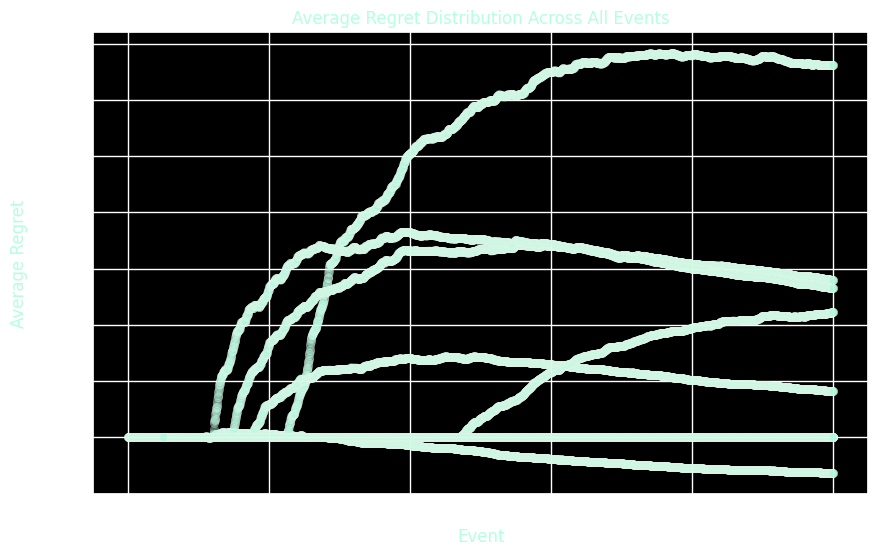

In [10]:
cols = set([c[0] for c in con.execute('SELECT * FROM events LIMIT 1').description])
if 'avg_regret' in cols:
    all_events = con.execute("SELECT grid_id, seed, event, avg_regret FROM events LIMIT 100000").df()
    print('all_events shape:', all_events.shape)
    if sns is not None:
        plt.figure(figsize=(10,6))
        plt.style.use('dark_background')
        sns.scatterplot(data=all_events, x='event', y='avg_regret', alpha=0.1, color=CUSTOM_PALETTE['aquamarine'])
        plt.title('Average Regret Distribution Across All Events', color=CUSTOM_PALETTE['aquamarine'])
        plt.xlabel('Event', color=CUSTOM_PALETTE['aquamarine'])
        plt.ylabel('Average Regret', color=CUSTOM_PALETTE['aquamarine'])
        plt.show()
    else:
        plt.figure(figsize=(10,6))
        plt.style.use('dark_background')
        plt.hist(all_events['avg_regret'], bins=50, color=CUSTOM_PALETTE['dark_cyan'], alpha=0.7)
        plt.title('Average Regret Distribution Across All Events', color=CUSTOM_PALETTE['aquamarine'])
        plt.xlabel('Average Regret', color=CUSTOM_PALETTE['aquamarine'])
        plt.ylabel('Frequency', color=CUSTOM_PALETTE['aquamarine'])
        plt.show()

Grid ID: e0a4b9b67329, shape: (49750, 2)


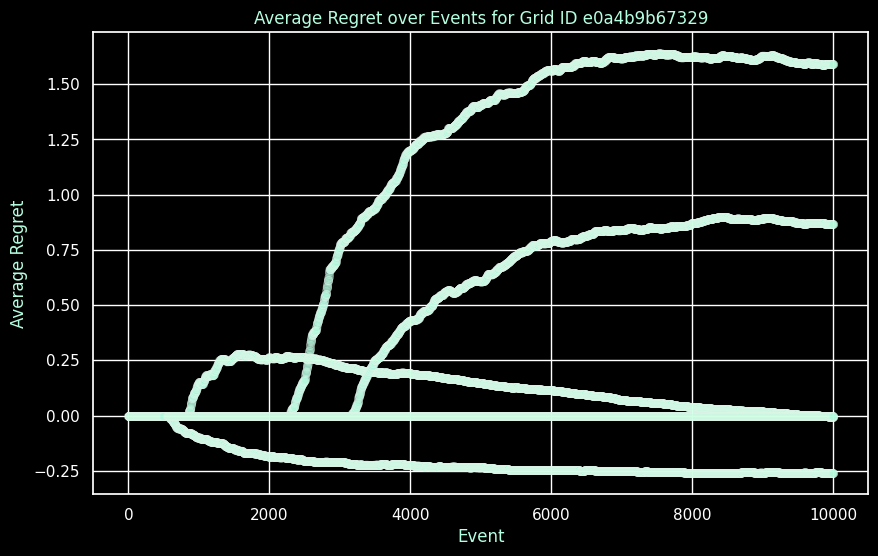

Grid ID: 94218ea1a6ab, shape: (49750, 2)


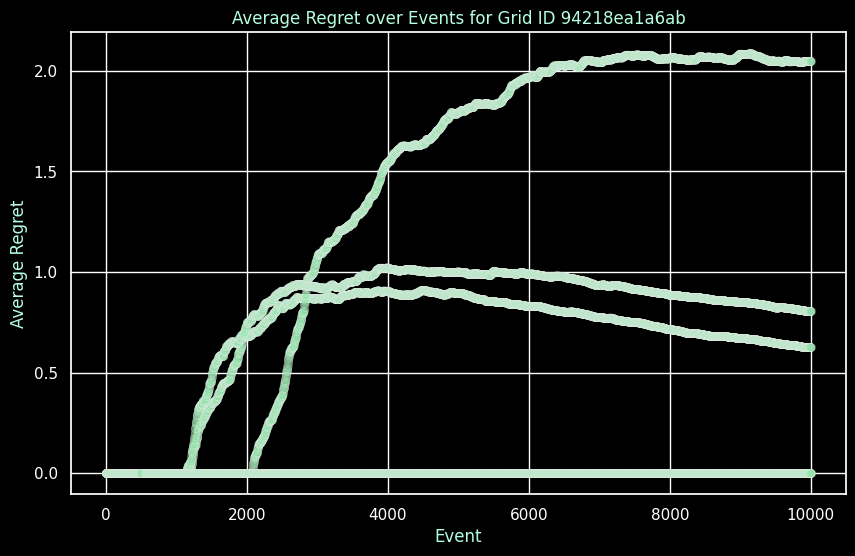

Grid ID: 7ea9ac97771a, shape: (49750, 2)


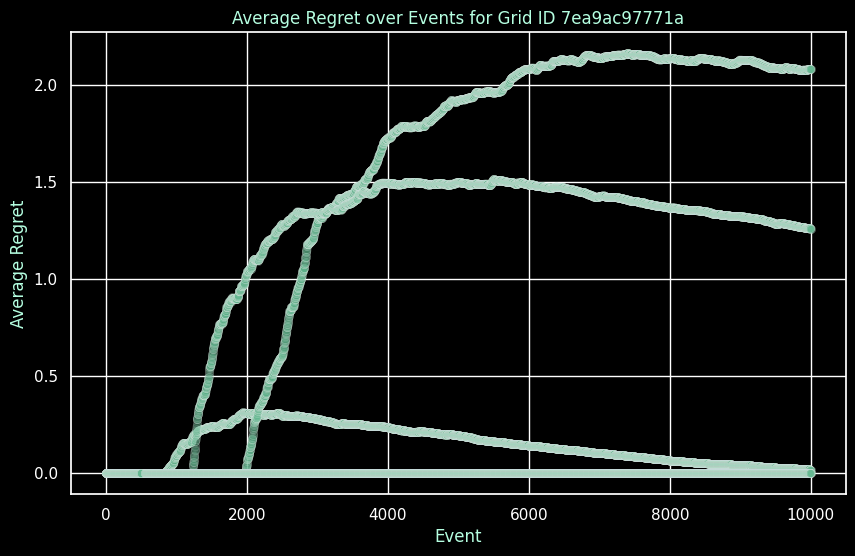

Grid ID: f2a66d3336d0, shape: (49750, 2)


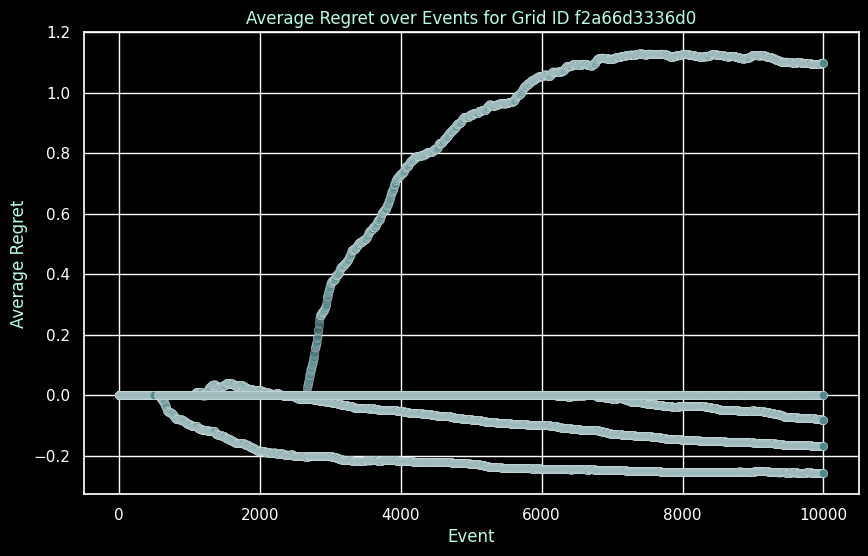

In [11]:
# plot one grid id per axis if regret and event columns exist
cols = set([c[0] for c in con.execute('SELECT * FROM events LIMIT 1').description])
if 'avg_regret' in cols and 'event' in cols:
    sample_grid_ids = grid_summary['grid_id'].unique()[:4]  # Limit to first 4 grid_ids for clarity
    for i, gid in enumerate(sample_grid_ids):
        grid_events = con.execute(f"SELECT event, avg_regret FROM events WHERE grid_id = '{gid}' LIMIT 100000").df()
        print(f'Grid ID: {gid}, shape: {grid_events.shape}')
        if sns is not None:
            plt.figure(figsize=(10,6))
            plt.style.use('dark_background')
            sns.scatterplot(data=grid_events, x='event', y='avg_regret', alpha=0.1, color=COLOR_SEQUENCE[i % len(COLOR_SEQUENCE)])
            plt.title(f'Average Regret over Events for Grid ID {gid}', color=CUSTOM_PALETTE['aquamarine'])
            plt.xlabel('Event', color=CUSTOM_PALETTE['aquamarine'])
            plt.ylabel('Average Regret', color=CUSTOM_PALETTE['aquamarine'])
            plt.show()
        else:
            plt.figure(figsize=(10,6))
            plt.style.use('dark_background')
            plt.scatter(grid_events['event'], grid_events['avg_regret'], alpha=0.1, color=COLOR_SEQUENCE[i % len(COLOR_SEQUENCE)])
            plt.title(f'Average Regret over Events for Grid ID {gid}', color=CUSTOM_PALETTE['aquamarine'])
            plt.xlabel('Event', color=CUSTOM_PALETTE['aquamarine'])
            plt.ylabel('Average Regret', color=CUSTOM_PALETTE['aquamarine'])
            plt.show()

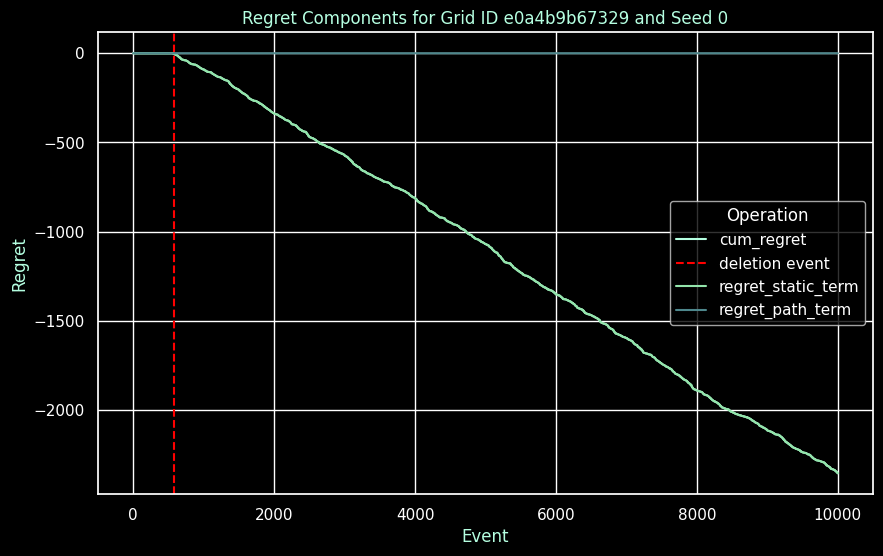

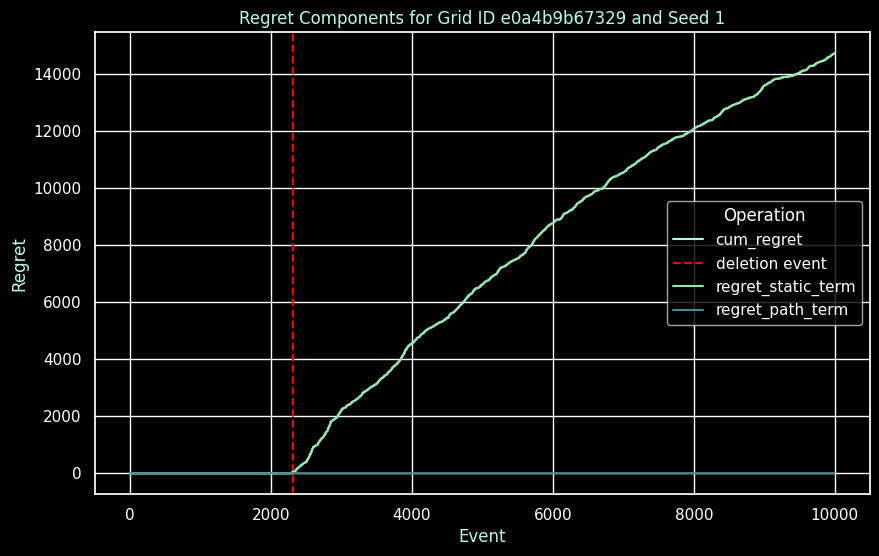

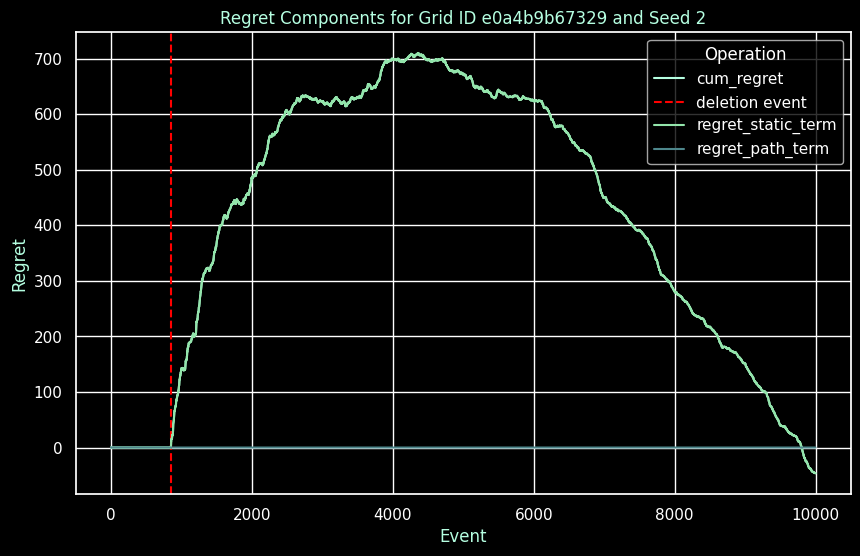

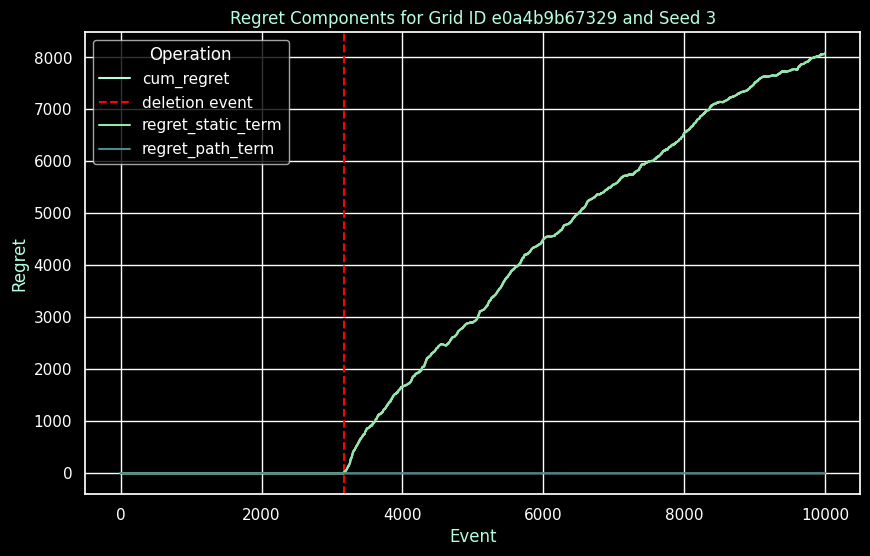

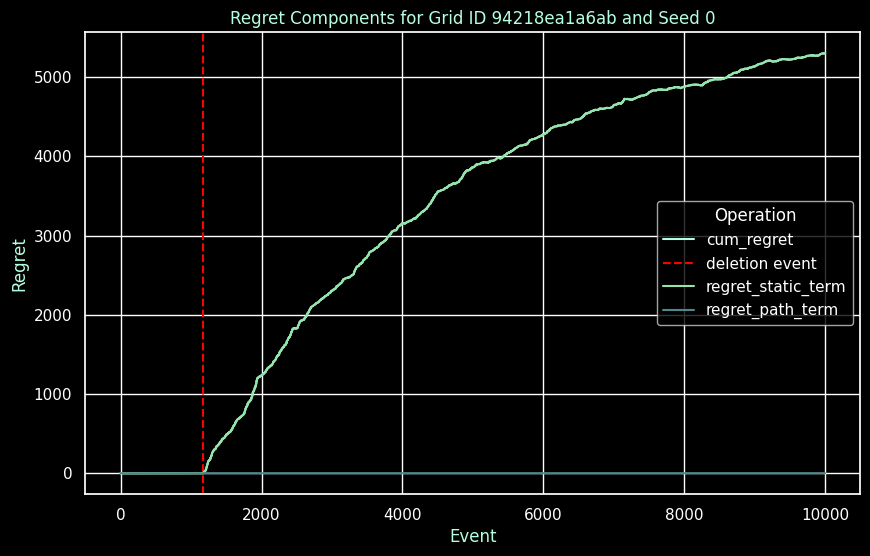

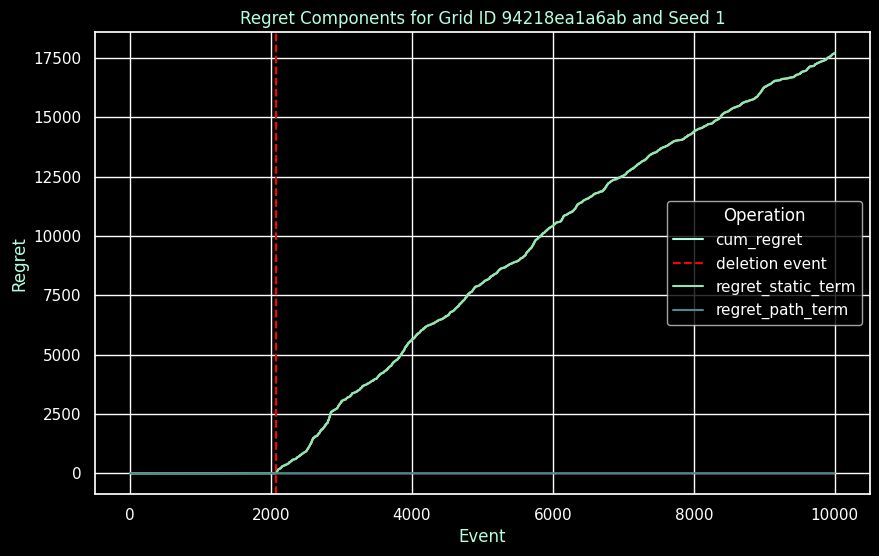

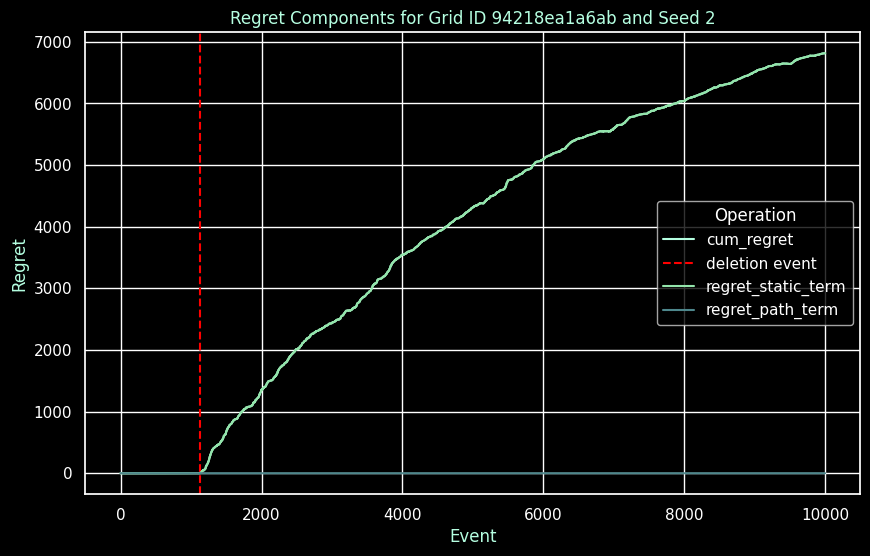

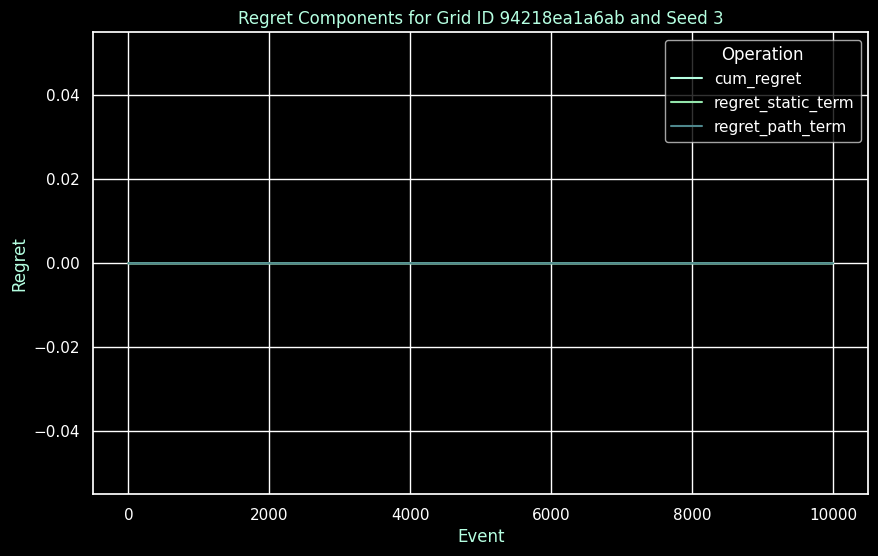

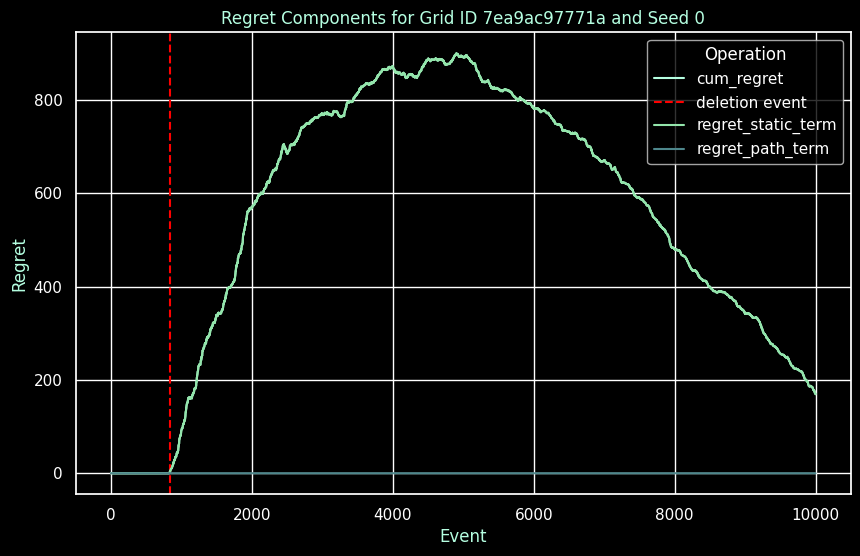

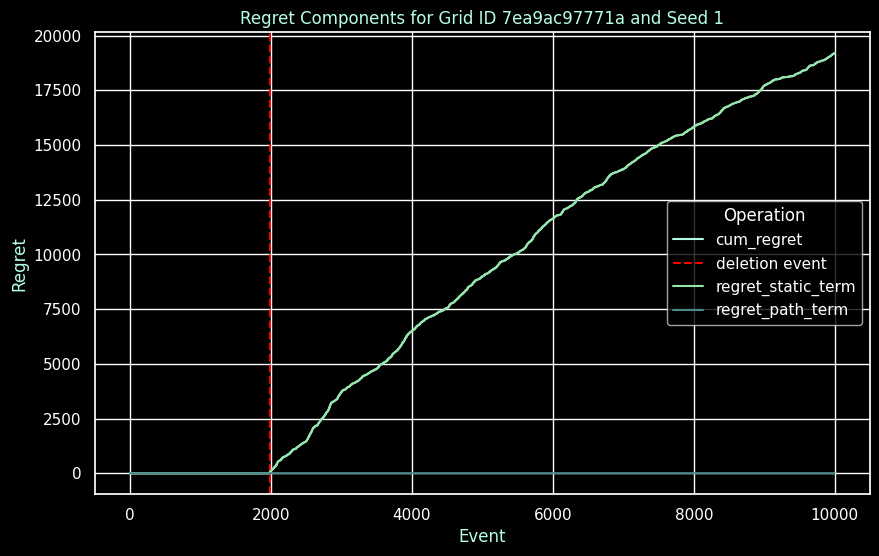

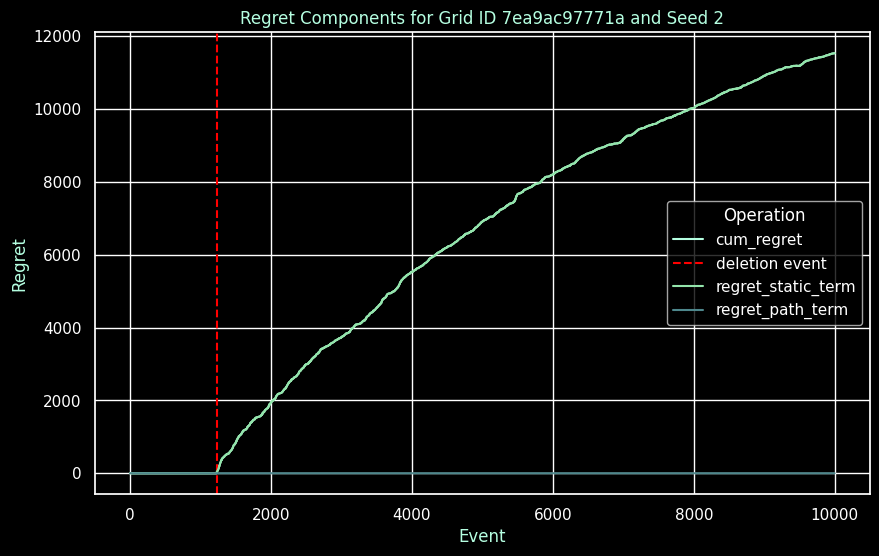

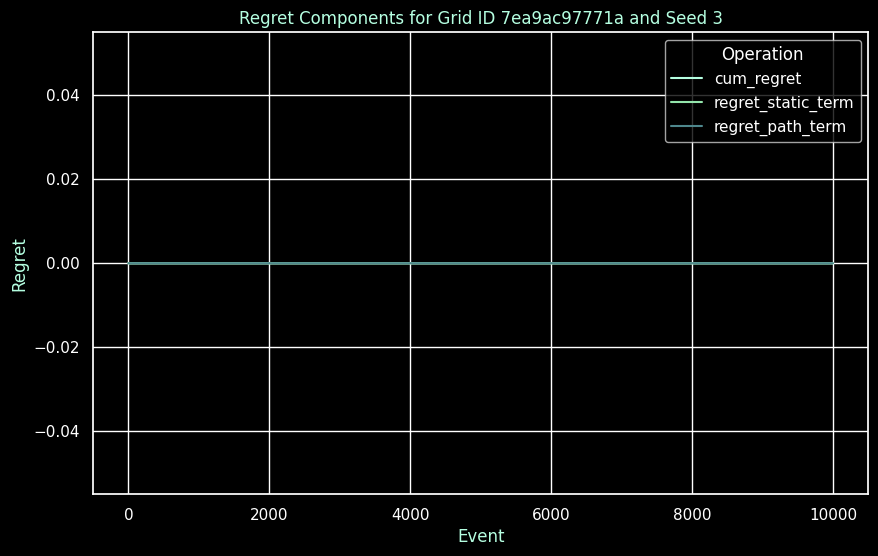

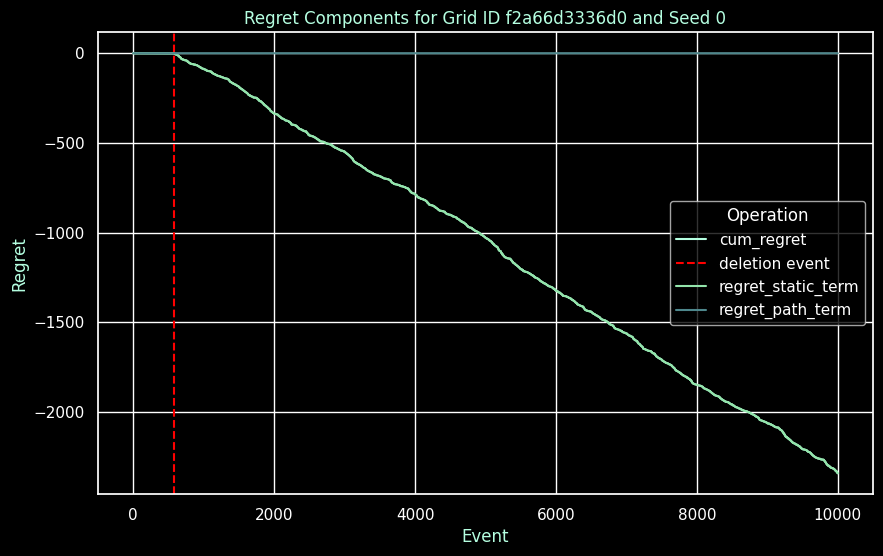

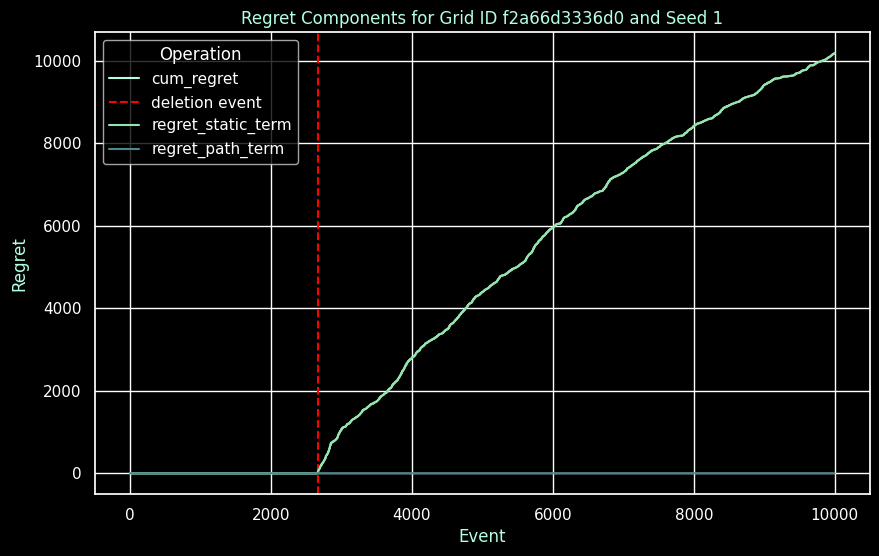

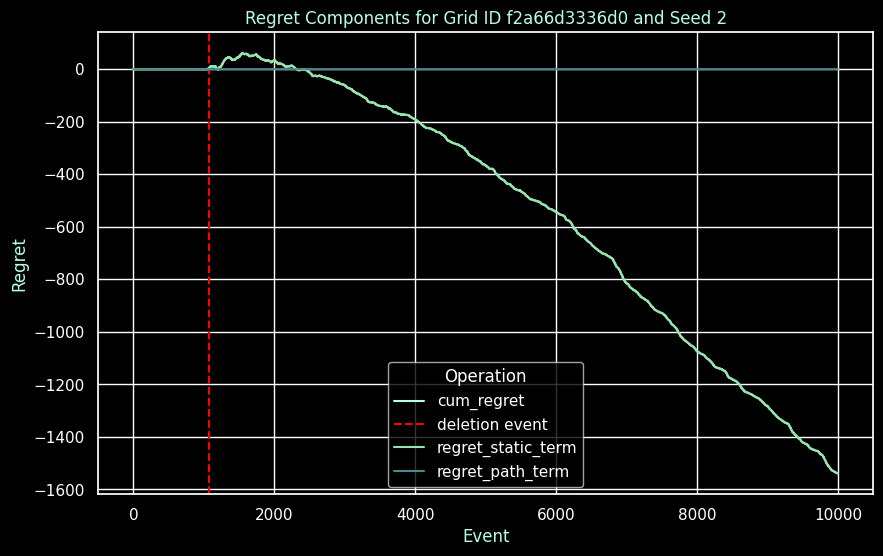

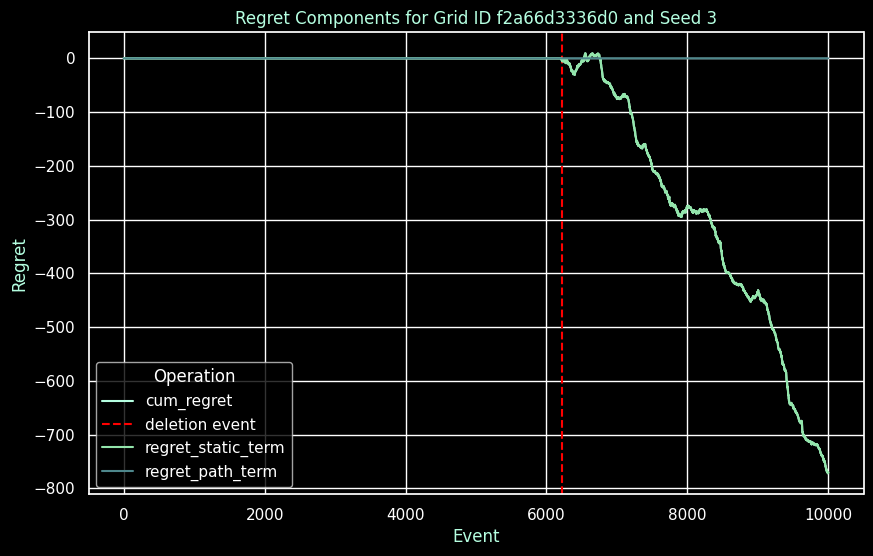

In [12]:
# plot one grid id x seed per axis if regret and event columns exist with overlays for op type
# with only a sample of N = 1000 points per grid_id for clarity
cols = set([c[0] for c in con.execute('SELECT * FROM events LIMIT 1').description])
sample_seeds = range(4)
if 'avg_regret' in cols and 'event' in cols and 'op' in cols:
    sample_grid_ids = grid_summary['grid_id'].unique()[:4]  # Limit to first 4 grid_ids for clarity
    for gid in sample_grid_ids:
        for seed in sample_seeds:
            grid_events = con.execute(f"SELECT event, cum_regret, regret_static_term, regret_path_term, op FROM events WHERE grid_id = '{gid}' AND seed = '{seed}'").df()
            # find the first deletion event
            deletion_event = con.execute(f"SELECT MIN(event) FROM events WHERE grid_id = '{gid}' AND seed = '{seed}' AND op = 'delete'")
            if deletion_event:
                deletion_event = deletion_event.fetchone()[0]
            else:
                deletion_event = None
            
            # plot cum_regret, static_regret_increment, and path_regret_increment, for sample grid IDs
            plt.figure(figsize=(10,6))
            plt.style.use('dark_background')
            plt.plot(grid_events['event'], grid_events['cum_regret'], label='cum_regret', color=CUSTOM_PALETTE['aquamarine'])
            if deletion_event:
                plt.axvline(x=deletion_event, color='red', linestyle='--', label='deletion event')
            plt.plot(grid_events['event'], grid_events['regret_static_term'], label='regret_static_term', color=CUSTOM_PALETTE['celadon'])
            plt.plot(grid_events['event'], grid_events['regret_path_term'], label='regret_path_term', color=CUSTOM_PALETTE['dark_cyan'])
            plt.title(f'Regret Components for Grid ID {gid} and Seed {seed}', color=CUSTOM_PALETTE['aquamarine'])
            plt.xlabel('Event', color=CUSTOM_PALETTE['aquamarine'])
            plt.ylabel('Regret', color=CUSTOM_PALETTE['aquamarine'])
            plt.legend(title='Operation')
            plt.show()


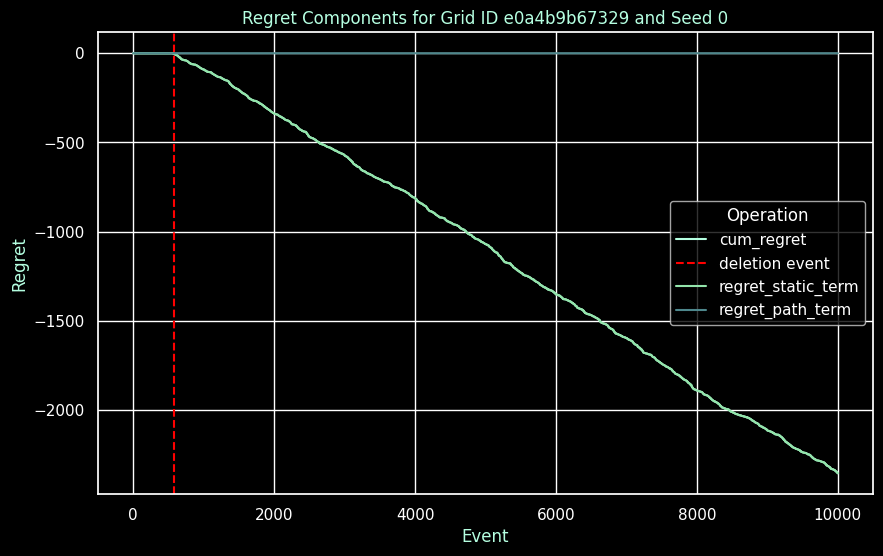

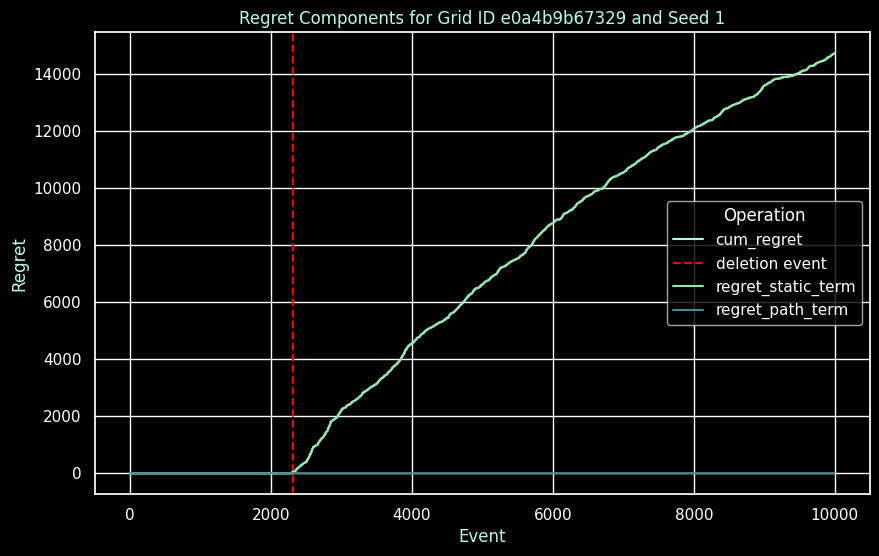

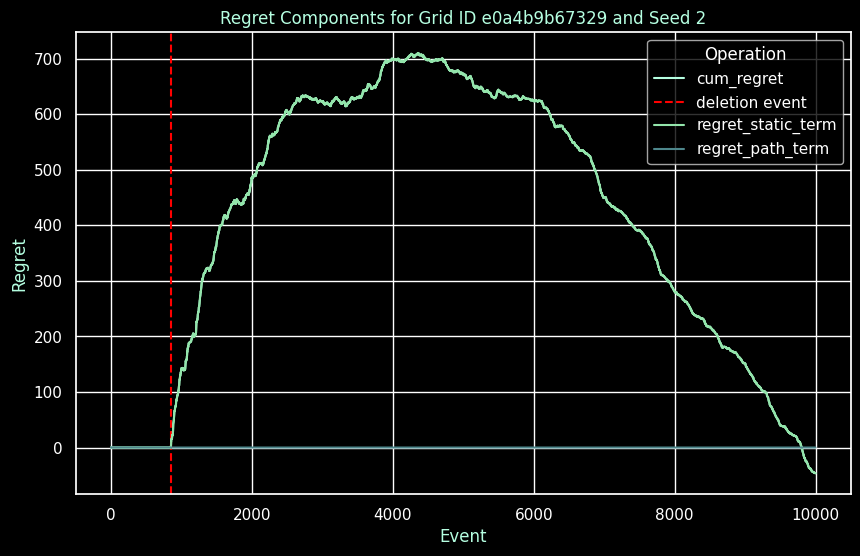

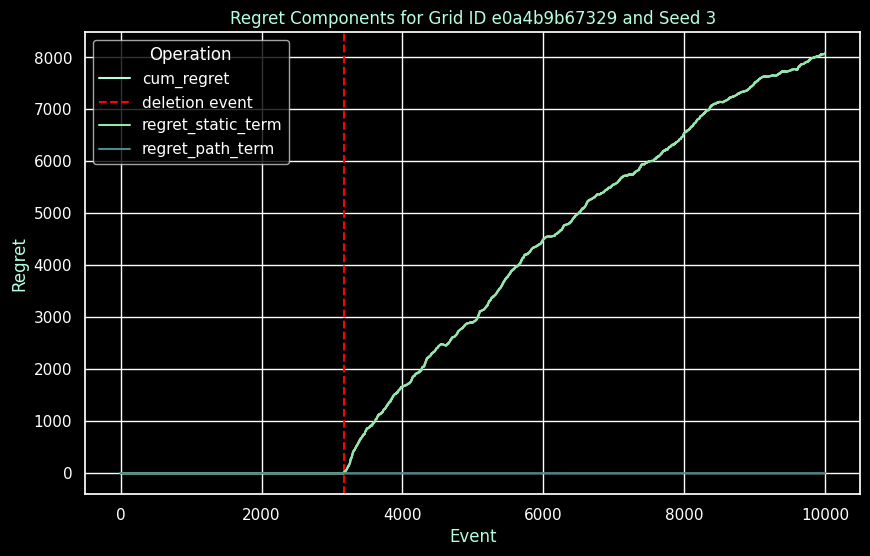

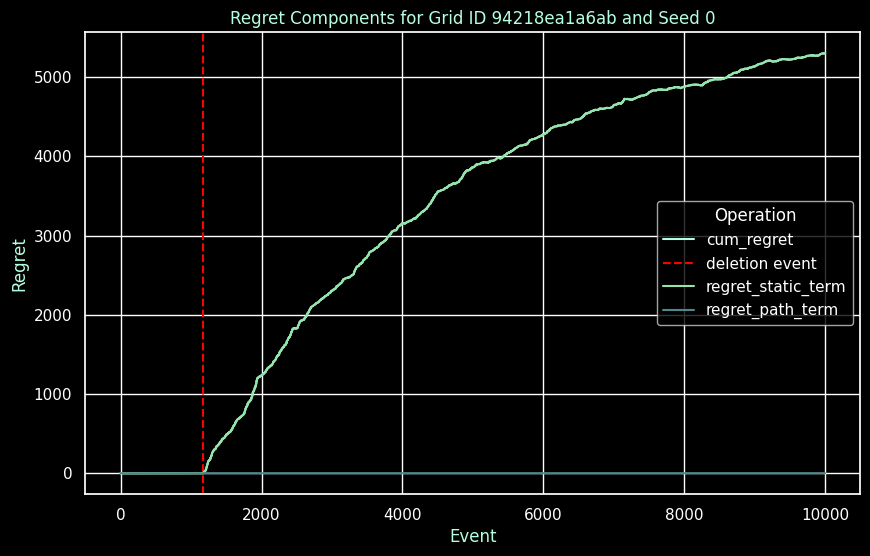

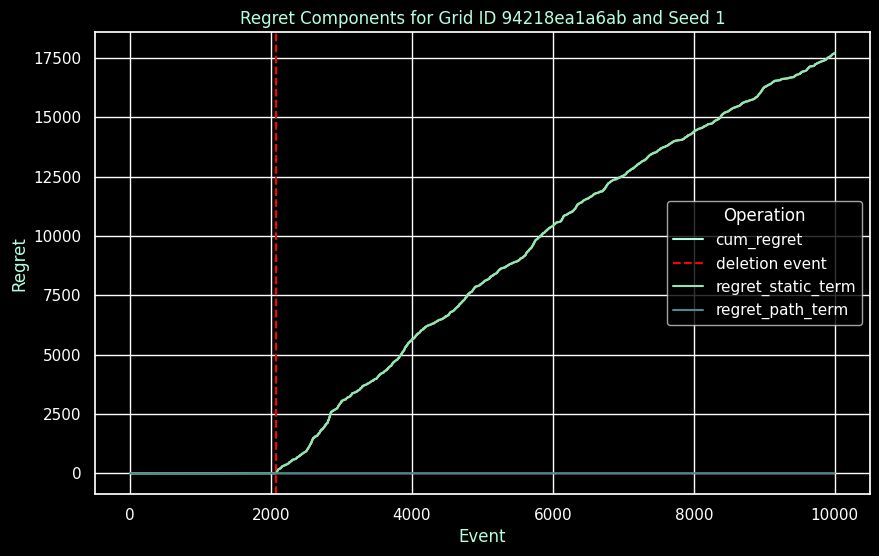

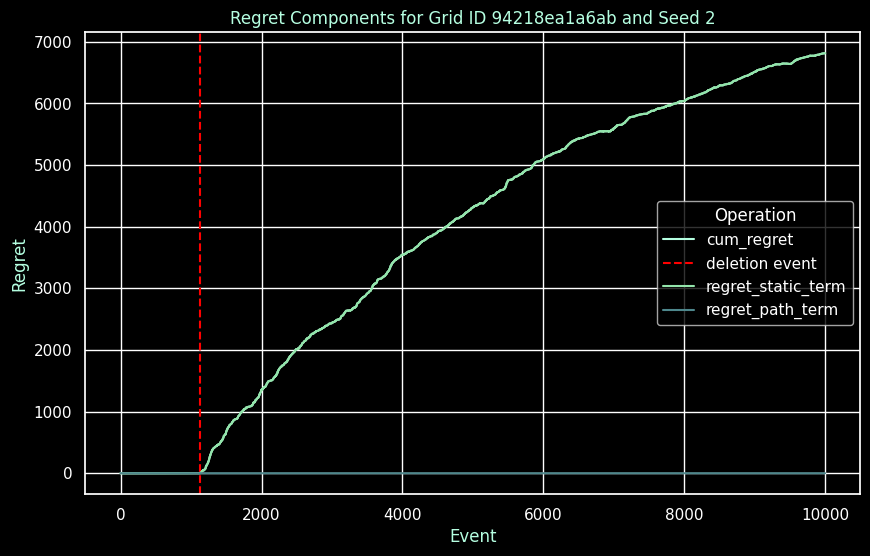

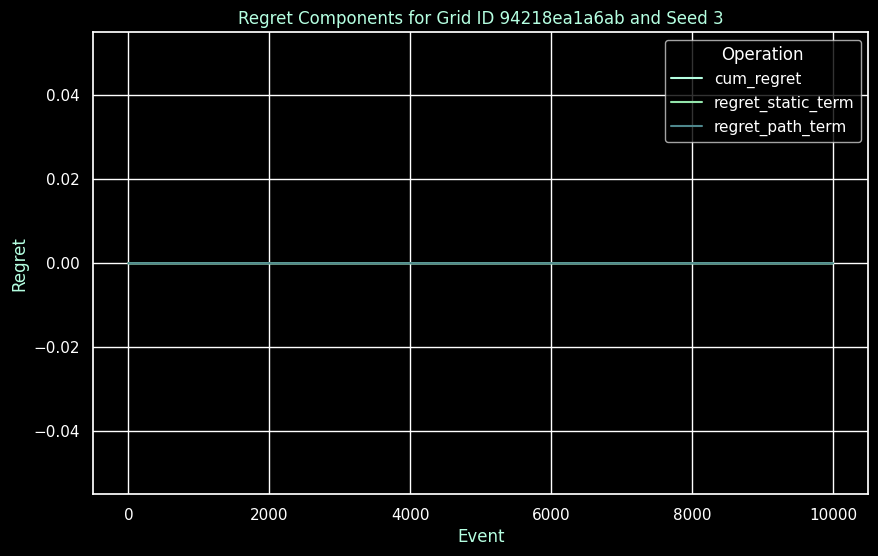

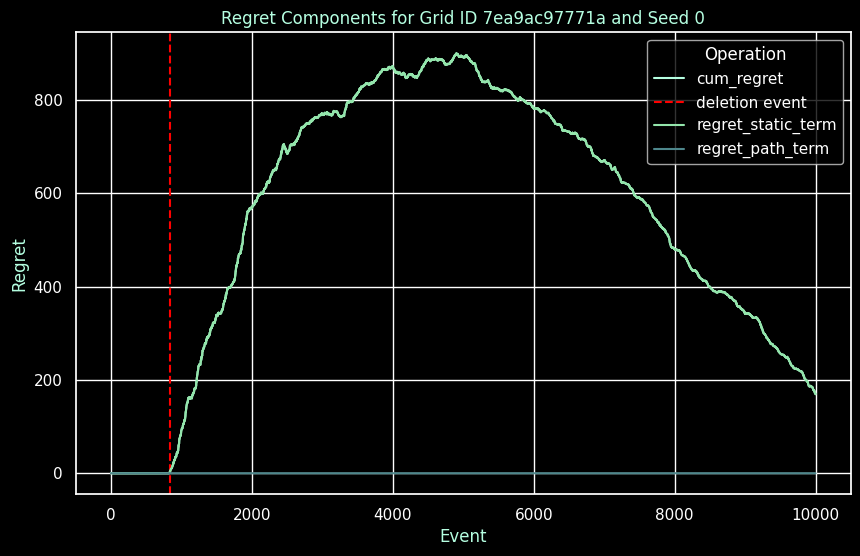

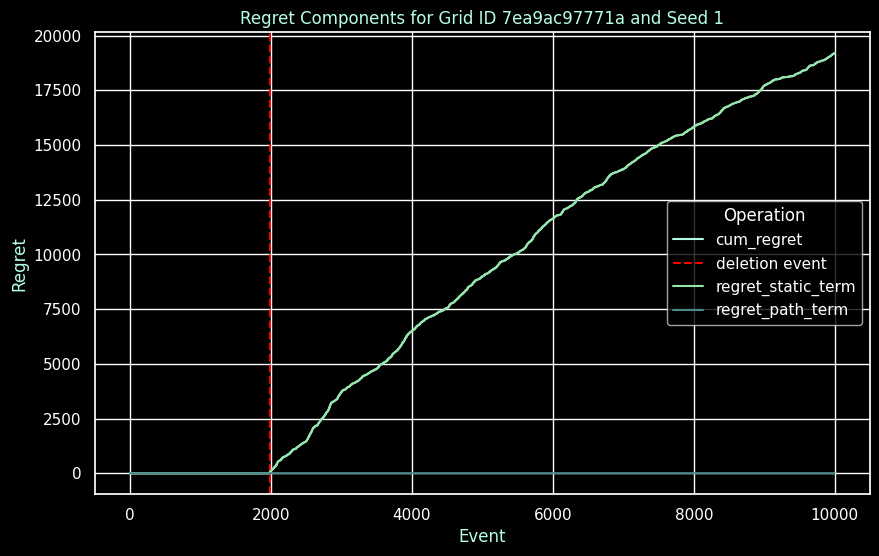

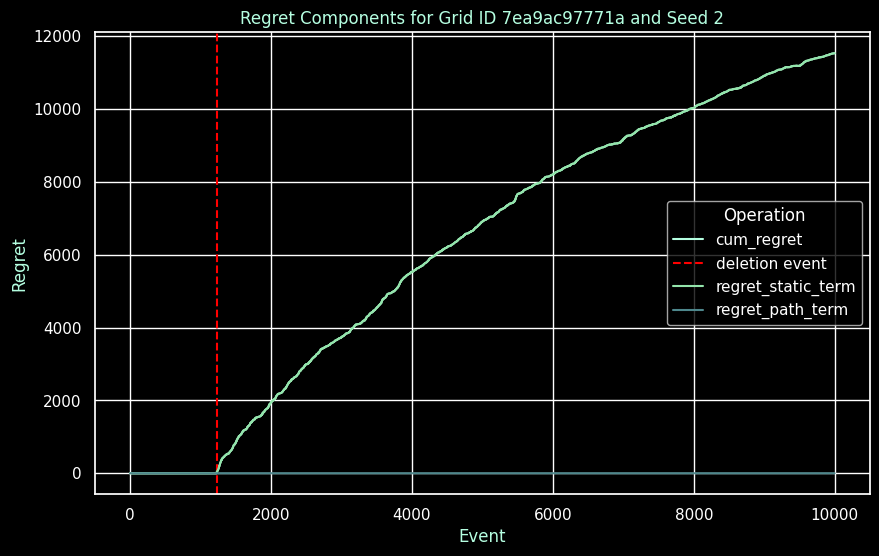

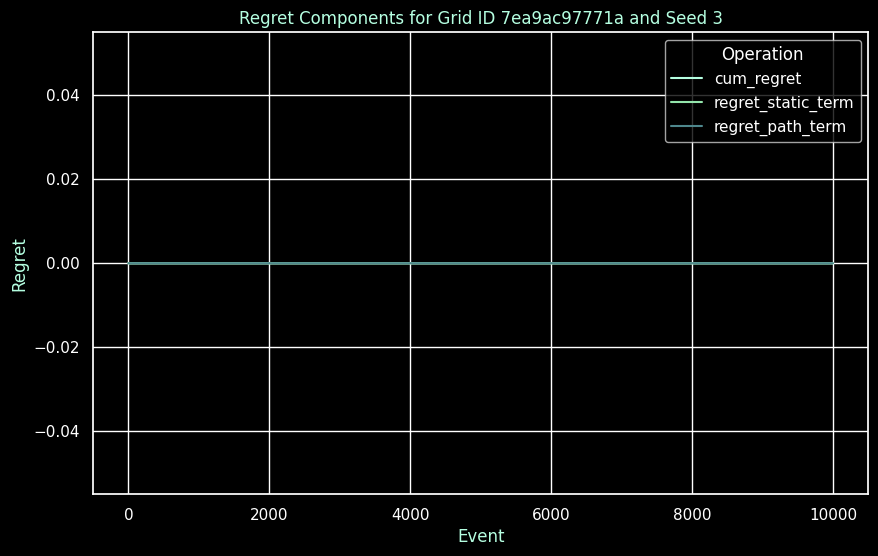

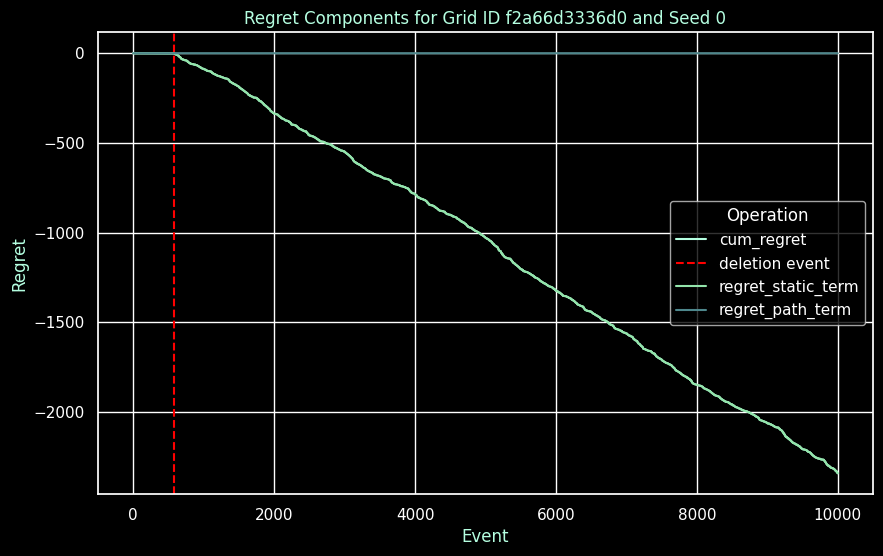

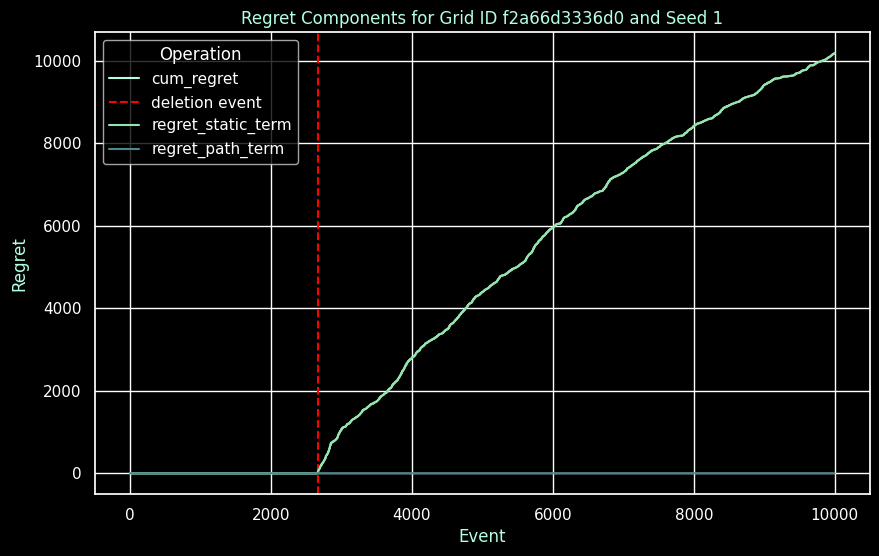

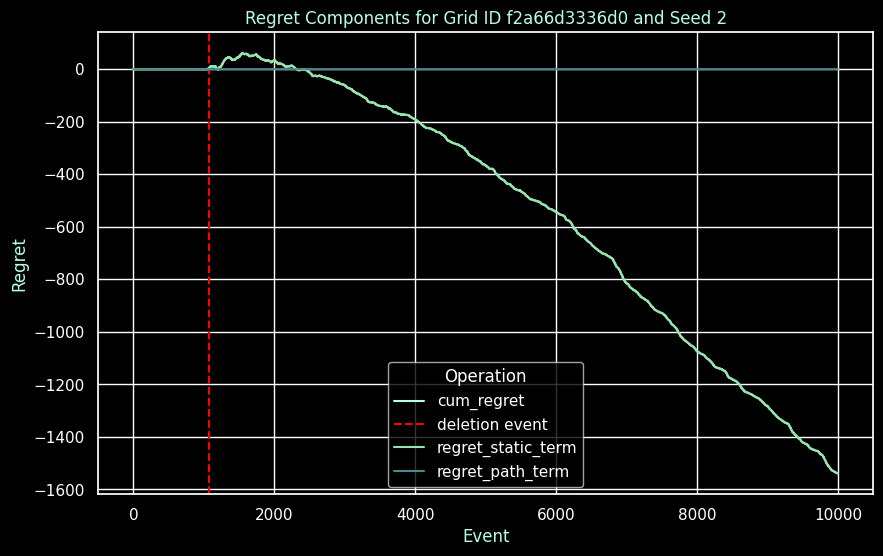

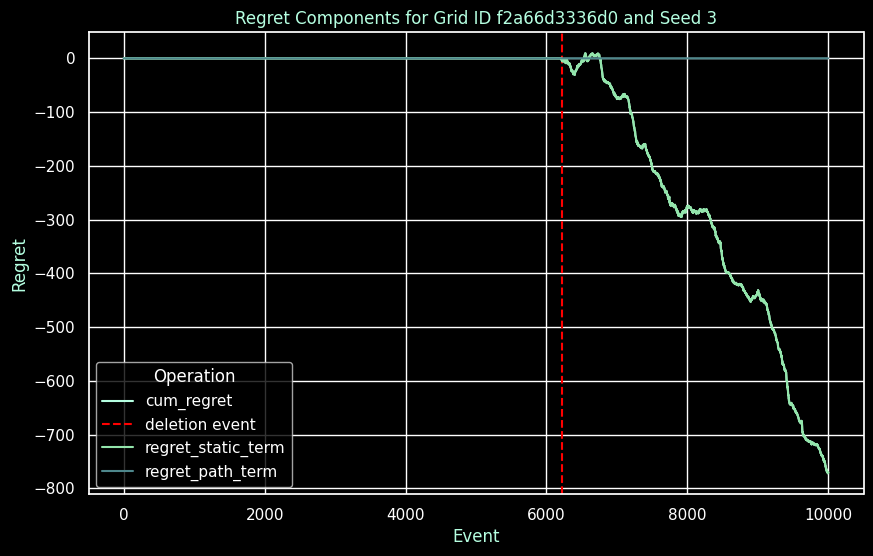

In [13]:
# plot one grid id x seed per axis if regret and event columns exist with overlays for op type
# with only a sample of N = 1000 points per grid_id for clarity
cols = set([c[0] for c in con.execute('SELECT * FROM events LIMIT 1').description])
sample_seeds = range(4)
if 'avg_regret' in cols and 'event' in cols and 'op' in cols:
    sample_grid_ids = grid_summary['grid_id'].unique()[:4]  # Limit to first 4 grid_ids for clarity
    for gid in sample_grid_ids:
        for seed in sample_seeds:
            grid_events = con.execute(f"SELECT event, cum_regret, regret_static_term, regret_path_term, op FROM events WHERE grid_id = '{gid}' AND seed = '{seed}'").df()
            # find the first deletion event
            deletion_event = con.execute(f"SELECT MIN(event) FROM events WHERE grid_id = '{gid}' AND seed = '{seed}' AND op = 'delete'")
            if deletion_event:
                deletion_event = deletion_event.fetchone()[0]
            else:
                deletion_event = None
            
            # plot cum_regret, static_regret_increment, and path_regret_increment, for sample grid IDs
            plt.figure(figsize=(10,6))
            plt.style.use('dark_background')
            plt.plot(grid_events['event'], grid_events['cum_regret'], label='cum_regret', color=CUSTOM_PALETTE['aquamarine'])
            if deletion_event:
                plt.axvline(x=deletion_event, color='red', linestyle='--', label='deletion event')
            plt.plot(grid_events['event'], grid_events['regret_static_term'], label='regret_static_term', color=CUSTOM_PALETTE['celadon'])
            plt.plot(grid_events['event'], grid_events['regret_path_term'], label='regret_path_term', color=CUSTOM_PALETTE['dark_cyan'])
            plt.title(f'Regret Components for Grid ID {gid} and Seed {seed}', color=CUSTOM_PALETTE['aquamarine'])
            plt.xlabel('Event', color=CUSTOM_PALETTE['aquamarine'])
            plt.ylabel('Regret', color=CUSTOM_PALETTE['aquamarine'])
            plt.legend(title='Operation')
            plt.show()
